[INFO] Applied Low-Pass Filter (14.0 Hz)

   CLINICAL MOVEMENT ANALYSIS (Threshold: +/- 30.0%)
METRIC                    | REF        | PATIENT    | STATUS         
----------------------------------------------------------------------
Overall SPARC             | -1.8665     | -4.0503     | FAIL
Choppiness (0-5Hz)        | -1.7746     | -2.2023     | PASS
Tremor (5-20Hz)           | -0.0918     | -1.8463     | FAIL
----------------------------------------------------------------------
Velocity RMSE             | 0.0000     | 0.6100     | FAIL (Timing)
Peak Velocity             | 1.0273     | 5.6958     | FAIL



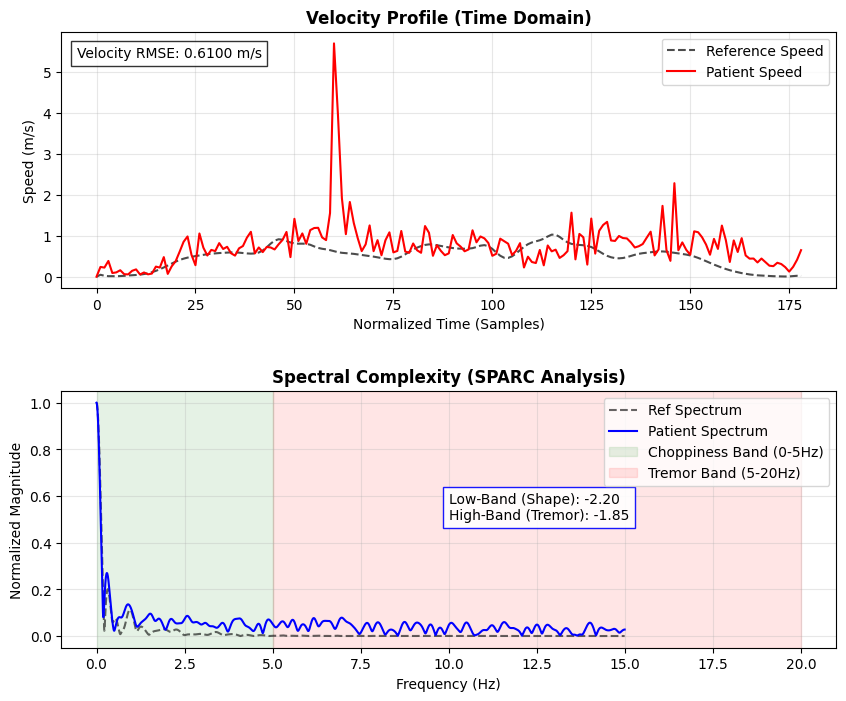

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, resample


class MovementAnalyzer:
    def __init__(self, fs=30, cutoff=12):
        self.fs = fs
        self.cutoff = cutoff

    def _low_pass_filter(self, data):
        """Applies 4th order Butterworth filter to remove camera jitter."""
        nyq = 0.5 * self.fs
        normal_cutoff = self.cutoff / nyq
        b, a = butter(4, normal_cutoff, btype='low', analog=False)
        
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[1]): # Iterate x, y, z
            filtered_data[:, i] = filtfilt(b, a, data[:, i])
        return filtered_data

    def _get_speed_profile(self, positions):
        """Calculates Euclidean speed from 3D positions."""
        velocity = np.diff(positions, axis=0) * self.fs
        # Insert 0 at start to match length (diff reduces length by 1)
        velocity = np.vstack([np.zeros(3), velocity]) 
        speed = np.sqrt(np.sum(velocity**2, axis=1))
        return speed

    def get_spectrum(self, speed_profile):
        """Helper to get spectrum data for plotting."""
        N = len(speed_profile)
        pad_level = 4
        n_fft = int(2**(np.ceil(np.log2(N)) + pad_level))
        
        spectrum = np.abs(fft(speed_profile, n_fft))
        dc = spectrum[0]
        if dc == 0: dc = 1.0 # Avoid div by zero
        
        norm_spec = spectrum / dc
        freqs = fftfreq(n_fft, d=1/self.fs)
        
        mask_pos = freqs >= 0
        return freqs[mask_pos], norm_spec[mask_pos]

    def calculate_sparc_components(self, speed_profile):
        """Calculates Overall, Low-Band, and High-Band SPARC scores."""
        freqs, norm_spec = self.get_spectrum(speed_profile)
        
        # Define Bands
        mask_total = (freqs <= FREQ_LIMIT_HIGH)
        mask_low = (freqs <= FREQ_LIMIT_LOW)
        mask_high = (freqs > FREQ_LIMIT_LOW) & (freqs <= FREQ_LIMIT_HIGH)
        
        # Arc Length Calculation Helper
        def get_arc_length(f_roi, s_roi):
            if len(f_roi) < 2: return 0.0
            df = f_roi[1] - f_roi[0]
            ds = np.diff(s_roi)
            # Scale factor (1/wc)^2 where wc = 20Hz (40pi)
            wc = 40 * np.pi
            integrand = np.sqrt((1/wc)**2 + (ds/df)**2)
            return -np.sum(integrand) * df 

        sparc_total = get_arc_length(freqs[mask_total], norm_spec[mask_total])
        sparc_low = get_arc_length(freqs[mask_low], norm_spec[mask_low])
        sparc_high = get_arc_length(freqs[mask_high], norm_spec[mask_high])
        
        return sparc_total, sparc_low, sparc_high

    def compare_performances(self, ref_pos, pat_pos, use_filter=True):
        # 1. Pre-process
        if use_filter:
            ref_final = self._low_pass_filter(ref_pos)
            pat_final = self._low_pass_filter(pat_pos)
            print(f"[INFO] Applied Low-Pass Filter ({self.cutoff} Hz)")
        else:
            ref_final = ref_pos
            pat_final = pat_pos
            print("[INFO] Using Raw Data (No Filtering)")
        
        # Calculate Speed Profiles
        ref_speed = self._get_speed_profile(ref_final)
        pat_speed = self._get_speed_profile(pat_final)
        
        # 2. SPARC Analysis
        ref_sparc, ref_low, ref_high = self.calculate_sparc_components(ref_speed)
        pat_sparc, pat_low, pat_high = self.calculate_sparc_components(pat_speed)
        
        # 3. Time-Domain Analysis
        pat_speed_resampled = resample(pat_speed, len(ref_speed))
        mse = np.mean((ref_speed - pat_speed_resampled)**2)
        vel_rmse = np.sqrt(mse)
        
        ref_peak = np.max(ref_speed)
        pat_peak = np.max(pat_speed)
        
        # 4. Return Metrics + Raw Data for Plotting
        metrics = {
            "Reference": {
                "Total_SPARC": ref_sparc, "Low_Band_SPARC": ref_low,
                "High_Band_SPARC": ref_high, "Peak_Velocity": ref_peak,
                "Mean_Velocity": np.mean(ref_speed)
            },
            "Patient": {
                "Total_SPARC": pat_sparc, "Low_Band_SPARC": pat_low,
                "High_Band_SPARC": pat_high, "Peak_Velocity": pat_peak,
                "Velocity_RMSE": vel_rmse
            },
            "Plot_Data": {
                "Ref_Speed": ref_speed, "Pat_Speed": pat_speed,
                "Ref_Pos": ref_final, "Pat_Pos": pat_final
            }
        }
        return metrics

# ==========================================
# VISUALIZATION FUNCTIONS
# ==========================================
def plot_clinical_graphs(analyzer, metrics):
    plot_data = metrics["Plot_Data"]
    ref_speed = plot_data["Ref_Speed"]
    pat_speed = plot_data["Pat_Speed"]
    
    # Get Spectral Data
    ref_freq, ref_spec = analyzer.get_spectrum(ref_speed)
    pat_freq, pat_spec = analyzer.get_spectrum(pat_speed)
    
    # Create Figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.4)
    
    # --- GRAPH 1: VELOCITY PROFILE (Time Domain) ---
    ax1.plot(ref_speed, 'k--', label='Reference Speed', alpha=0.7)
    # Resample patient to match reference length strictly for visualization alignment
    pat_resampled_vis = resample(pat_speed, len(ref_speed))
    ax1.plot(pat_resampled_vis, 'r-', label='Patient Speed', linewidth=1.5)
    
    ax1.set_title("Velocity Profile (Time Domain)", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Speed (m/s)")
    ax1.set_xlabel("Normalized Time (Samples)")
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Annotate RMSE
    rmse_val = metrics["Patient"]["Velocity_RMSE"]
    ax1.text(0.02, 0.9, f"Velocity RMSE: {rmse_val:.4f} m/s", transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))

    # --- GRAPH 2: SPECTRAL ARC (Frequency Domain) ---
    # Only plot up to 25Hz (relevant range)
    mask_ref = ref_freq <= 25
    mask_pat = pat_freq <= 25
    
    ax2.plot(ref_freq[mask_ref], ref_spec[mask_ref], 'k--', label='Ref Spectrum', alpha=0.6)
    ax2.plot(pat_freq[mask_pat], pat_spec[mask_pat], 'b-', label='Patient Spectrum', linewidth=1.5)
    
    # Highlight Bands
    ax2.axvspan(0, 5, color='green', alpha=0.1, label='Choppiness Band (0-5Hz)')
    ax2.axvspan(5, 20, color='red', alpha=0.1, label='Tremor Band (5-20Hz)')
    
    ax2.set_title("Spectral Complexity (SPARC Analysis)", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Normalized Magnitude")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Annotate Scores
    pat_scores = metrics["Patient"]
    score_text = (f"Low-Band (Shape): {pat_scores['Low_Band_SPARC']:.2f}\n"
                  f"High-Band (Tremor): {pat_scores['High_Band_SPARC']:.2f}")
    ax2.text(0.5, 0.5, score_text, transform=ax2.transAxes, 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='blue'))

    plt.show()

def print_clinical_report(metrics, threshold_pct):
    ref = metrics["Reference"]
    pat = metrics["Patient"]
    
    print("\n" + "="*70)
    print(f"   CLINICAL MOVEMENT ANALYSIS (Threshold: +/- {threshold_pct*100}%)")
    print("="*70)
    print(f"{'METRIC':<25} | {'REF':<10} | {'PATIENT':<10} | {'STATUS':<15}")
    print("-" * 70)
    
    # Helper to print rows
    def print_row(name, ref_val, pat_val, limit, is_upper_limit=False):
        if is_upper_limit: passed = pat_val < limit
        else: passed = pat_val > limit
        status = "PASS" if passed else "FAIL"
        print(f"{name:<25} | {ref_val:.4f}     | {pat_val:.4f}     | {status}")

    # 1. Overall SPARC
    sparc_limit = ref["Total_SPARC"] - abs(ref["Total_SPARC"] * threshold_pct)
    print_row("Overall SPARC", ref["Total_SPARC"], pat["Total_SPARC"], sparc_limit)
    
    # 2. Choppiness (Low Band)
    low_limit = ref["Low_Band_SPARC"] - abs(ref["Low_Band_SPARC"] * threshold_pct)
    print_row("Choppiness (0-5Hz)", ref["Low_Band_SPARC"], pat["Low_Band_SPARC"], low_limit)

    # 3. Tremor (High Band)
    high_limit = ref["High_Band_SPARC"] - abs(ref["High_Band_SPARC"] * threshold_pct)
    print_row("Tremor (5-20Hz)", ref["High_Band_SPARC"], pat["High_Band_SPARC"], high_limit)

    print("-" * 70)

    # 4. Bradykinesia (RMSE)
    rmse_limit = ref["Mean_Velocity"] * threshold_pct
    status = "PASS" if pat["Velocity_RMSE"] < rmse_limit else "FAIL (Timing)"
    print(f"{'Velocity RMSE':<25} | {'0.0000':<10} | {pat['Velocity_RMSE']:.4f}     | {status}")
    
    # 5. Spasm (Peak Spike)
    peak_limit = ref["Peak_Velocity"] * (1 + threshold_pct)
    print_row("Peak Velocity", ref["Peak_Velocity"], pat["Peak_Velocity"], peak_limit, is_upper_limit=True)
    
    print("="*70 + "\n")

# ==========================================
# MAIN EXECUTION
# ==========================================
def load_data(path):
    try:
        df = pd.read_excel(path)
    except:
        df = pd.read_csv(path)
    return df[['Wrist_x', 'Wrist_y', 'Wrist_z']].dropna().values

if __name__ == "__main__":
    # 1. FILE PATHS
    REF = r"C:\Users\LOQ\Desktop\Uni Work\FYP\Depth Data\Reference Templates\right_wrist_template_10_trails_demo.xlsx"
    PAT = r"C:\Users\LOQ\Desktop\Uni Work\FYP\Depth Data\MediaPipe Dataset\Shahmir\right_arm_motion_eigth_realsense_(3).xlsx"
    
    try:
        ref_data = load_data(REF)
        pat_data = load_data(PAT)
        # ==========================================
        # CONSTANTS (Frequency Bands from Literature)
        # ==========================================
        FREQ_LIMIT_LOW = 5.0     # 0-5Hz (Shape/Choppiness)
        FREQ_LIMIT_HIGH = 20.0   # 5-20Hz (Tremor)
        SAMPLE_RATE = 30.0       # Frames Per Second (Camera FPS)

                
        # ==========================================
        # EDITABLE PARAMETERS
        # ==========================================
        ENABLE_FILTERING = True   # Set to True to clean camera noise
        FILTER_FREQ = 14.0        # Cutoff Frequency in Hz
        THRESHOLD_PERCENT = 0.30  # 20% tolerance
        # ==========================================

        analyzer = MovementAnalyzer(fs=SAMPLE_RATE, cutoff=FILTER_FREQ)
        metrics = analyzer.compare_performances(ref_data, pat_data, use_filter=ENABLE_FILTERING)
        
        print_clinical_report(metrics, THRESHOLD_PERCENT)
        plot_clinical_graphs(analyzer, metrics)
        
    except Exception as e:
        print(f"Error: {e}")